In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import json
import pandas as pd
import twitter_functions as tf
import ct_functions as ctf
import time
import matplotlib.pyplot as plt
import numpy as np
import math

from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
domain_src = '../resources/domains/clean'
domains = pd.read_csv(join(domain_src, 'domain_list_clean.csv'))
domains['active'] = 'unknown'
harmful_domains = domains[domains['type'] == "unreliable"]

# Query tweets containing misinformation domains

Query the full archival endpoint for every domain with a harm score > 6 to see if there were tweets mentioning that domain in the last month (April 24th to May 24th 2021). 

In [3]:
with open("api-keys/valentin.json") as f:
    api_keys = json.load(f)

In [ ]:
reload(tf)

tweet_dst = '../resources/tweets'

# query parameters: query returns a maximum number of 10 tweets for the given
# query
with open('params/misinfo_user_query.json') as json_file:
    params = json.load(json_file)

for index, domain in harmful_domains['url'].iteritems():
    print(index, domain)
    params['query'] = domain
    tweet_file_name = '{}.txt'.format(domain).replace('/', '_')
    
    config = {
      "bearer_token": api_keys["bearer-token"],
      "params": params,
      "write_path": join(tweet_dst, tweet_file_name)
    }

    tf.validate_config(config)
    
    count = 0
    next_token = None

    while count < config['params']['max_results']:

        json_response, error = tf.search_tweets(config, next_token, all=False)
        if error:
            with open(join(tweet_dst, "error-" + tweet_file_name), "w") as f:
                json.dump(json_response, f)
            break
        else:
            tweets = tf.get_formatted_tweets(json_response)
            # if the query returned tweets, save them for good measure, even if
            # we don't need them at this point
            if len(tweets) > 0:
                tf.write_to_file(config['write_path'], tweets)
            
            # store the number of tweets retrieved by the query in the "active"
            # column. Most queries will yield 0 or max_tweets (=10) tweets, but
            # there will be a few that yield something in between. Thats interesting
            # information.
            domains.loc[index, 'active'] = len(tweets)
            result_count = json_response['meta']['result_count']
            count += result_count

            # since we are only querying a maximum of 10 tweets here, this should
            # not be invoked.
            if 'meta' in json_response and 'next_token' in json_response['meta']:
                next_token = json_response['meta']['next_token']
            else:
                break
            
active = domains[(domains['harm_score'] > 6)]
active = active[active['active'] >= 10]
active.to_csv(join('../resources/domains/active/domain_list_active.csv'), index=False)

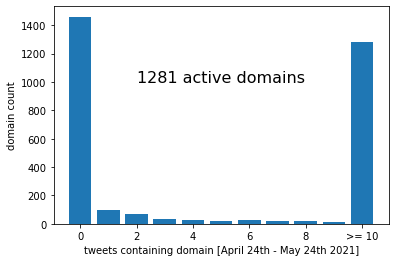

In [170]:
fig, ax = plt.subplots()
active = domains[domains['harm_score'] > 6]
ax.hist(active['active'], rwidth=0.8, bins=np.arange(-0.5, 11.5, 1))
ax.text(2, 1000, '{} active domains'\
        .format(len(active[active['active'] >= 10])), fontsize=16)
ax.set_xticks(range(0, 11, 2))
ax.set_xticklabels(list(range(0, 10, 2)) + ['>= 10'])
ax.set_ylabel('domain count')
ax.set_xlabel('tweets containing domain [April 24th - May 24th 2021]')
plt.savefig('../plots/domains/tw_active_domains.pdf')

# Query CrowdTangle for misinformation domains

In [3]:
# Write CrowdTangle query string in separate file
domain_list = harmful_domains["url"].values
for i in range(math.ceil(len(domain_list) / 1024)):
    with open(f"configs/ct-query-batch{i}.txt", "w") as f:
        start, end = i * 1024, (i + 1) * 1024
        f.write(",".join(domain_list[start:end]))

In [4]:
list_ids = {
    "pages": ["1551087", "1551566", "1551567"],
    "groups": ["1551568", "1551571", "1551575"]
}
ct_src = "../resources/ct"
posts_src = "../resources/ct-posts"
links_src = "../resources/ct-links"
for src in [ct_src, posts_src, links_src]:
    if not os.path.exists(src):
        os.mkdir(src)

In [161]:
params = {
    "token": "9J4LRiuCxEO51I296LzpYByxieGg2heIyZVUYR7I",
    "listIds": ",".join(list_ids["pages"] + list_ids["groups"]),
    "sortBy": "date"
}
ctf.get_posts(params, posts_src, max_queries=42)

In [5]:
params = {
    "token": "9J4LRiuCxEO51I296LzpYByxieGg2heIyZVUYR7I",
    "sortBy": "date"
}
ctf.get_links(domain_list, params, links_src, max_queries=None, max_queries_per_link=1)

100%|██████████| 2154/2154 [2:29:51<00:00,  4.17s/it]


In [7]:
domain_indices = pd.read_csv(join(links_src, "domain-indices.csv"))
for index, domain in harmful_domains['url'].iteritems():
    path = join(links_src, f"link{index}-0.json")
    if os.path.exists(path):
        with open(join(links_src, f"link{index}-0.json"), "r") as f:
            link_posts = json.load(f)["posts"]
            harmful_domains.loc[index, 'active'] = len(link_posts)
    else:
        harmful_domains.loc[index, 'active'] = 0

c:\Users\Valentin\Documents\Studium\12. Semester - Masterarbeit\misinformation_tools\.venv\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


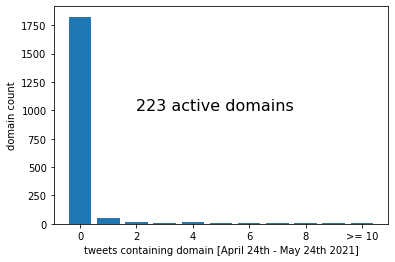

In [8]:
fig, ax = plt.subplots()
ax.hist(harmful_domains['active'], rwidth=0.8, bins=np.arange(-0.5, 11.5, 1))
ax.text(2, 1000, f"{len(harmful_domains[harmful_domains['active'] >= 10])} active domains", fontsize=16)
ax.set_xticks(range(0, 11, 2))
ax.set_xticklabels(list(range(0, 10, 2)) + ['>= 10'])
ax.set_ylabel('domain count')
ax.set_xlabel('tweets containing domain [April 24th - May 24th 2021]')
plt.savefig('../plots/domains/ct_active_domains.pdf')

In [25]:
harmful_domains.sort_values(by="active", ascending=False).head()

,url,label,source,last_update,accuracy,transparency,type,active
2135,cap-news.com,fake,columbia_journalism_review,2021-04,1,1,unreliable,1000
888,lacucinasiciliana.altervista.org,pseudojournalism blogs,butac,2021-05-18,1,1,unreliable,1000
598,usapoliticszone.com,fake news,girnberg,2019-01-28,1,1,unreliable,1000
1103,altrarealta.blogspot.it,conspiracy blogs,butac,2021-05-18,1,1,unreliable,1000
593,usanewshome.com,fake news,girnberg,2019-01-28,1,1,unreliable,1000


In [20]:
# merge all files
link_posts = []
for f_name in os.listdir(links_src):
    if f_name.endswith(".json"):
        with open(join(links_src, f_name)) as f:
            link_posts += json.load(f)["posts"]
with open(join(ct_src, "links.json"), "w") as f:
    json.dump(link_posts, f)

In [21]:
posts_df = pd.read_json(join(ct_src, "links.json"))
posts_df.shape

(209266, 25)

In [22]:
posts_df["date"].min(), posts_df["date"].max()

(Timestamp('2021-08-24 11:19:02'), Timestamp('2021-09-23 11:41:42'))

In [23]:
posts_df.head()

,platformId,platform,date,updated,type,description,expandedLinks,link,postUrl,subscriberCount,...,legacyId,id,title,caption,message,imageText,videoLengthMS,likeAndViewCountsDisabled,liveVideoStatus,brandedContentSponsor
0,1.001496e+29,Facebook,2021-09-23 10:10:22,2021-09-23 10:12:19,photo,The exports of cutlery from the country witnes...,"[{'original': 'rb.gy/ajpkjk', 'expanded': 'htt...",https://www.facebook.com/tdapofficial/photos/a...,https://www.facebook.com/100149588172966/posts...,1599,...,0,11092849|400406368147285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.738330e+27,Facebook,2021-09-23 07:16:38,2021-09-23 10:19:26,link,Eruptions from a volcanic grew in intensity We...,[{'original': 'https://nation.com.pk/23-Sep-20...,https://nation.com.pk/23-Sep-2021/volcanic-eru...,https://www.facebook.com/57383301711/posts/101...,1504214,...,0,5729|10158149883776712,Volcanic eruptions intensify on Spain's Canary...,nation.com.pk,Roads on the island have been closed for a wee...,NaN,NaN,NaN,NaN,NaN
2,5.738330e+27,Facebook,2021-09-23 07:00:15,2021-09-23 10:19:26,link,Changes in the cabinet have become a regularit...,[{'original': 'https://nation.com.pk/23-Sep-20...,https://nation.com.pk/23-Sep-2021/another-change,https://www.facebook.com/57383301711/posts/101...,1504214,...,0,5729|10158149868616712,Another Change,nation.com.pk,"[Editorial] ""The leadership needs to consider ...",NaN,NaN,NaN,NaN,NaN
3,5.738330e+27,Facebook,2021-09-23 06:48:58,2021-09-23 10:19:26,link,"A US Think-tank, Freedom House, released their...",[{'original': 'https://nation.com.pk/23-Sep-20...,https://nation.com.pk/23-Sep-2021/online-freedoms,https://www.facebook.com/57383301711/posts/101...,1504214,...,0,5729|10158149867576712,Online Freedoms,nation.com.pk,"[Editorial] ""We have made leaps in the field o...",NaN,NaN,NaN,NaN,NaN
4,5.738330e+27,Facebook,2021-09-23 06:33:22,2021-09-23 10:19:26,link,Prime Minister Imran Khan on Thursday congratu...,[{'original': 'https://nation.com.pk/23-Sep-20...,https://nation.com.pk/23-Sep-2021/pm-khan-cong...,https://www.facebook.com/57383301711/posts/101...,1504214,...,0,5729|10158149870621712,PM Khan congratulates Saudi leadership on Nati...,nation.com.pk,The premier wish the kingdom continued progres...,NaN,NaN,NaN,NaN,NaN
